<a href="https://colab.research.google.com/github/enriquetracker/ProyectoPokemon/blob/main/ProyectoPokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import Counter
from collections import Counter
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedagger/pokemon-generation-one")

print("Path to dataset files:", path)

 10%|█         | 231M/2.15G [00:04<00:40, 51.4MB/s]


KeyboardInterrupt: 

In [4]:
import shutil

source_path = path + "/dataset"
destination_path = "./"

shutil.move(source_path, destination_path)
print(f"Dataset movido a: {destination_path}")

NameError: name 'path' is not defined

Total number of categories: 150
Total number of images in dataset: 10842


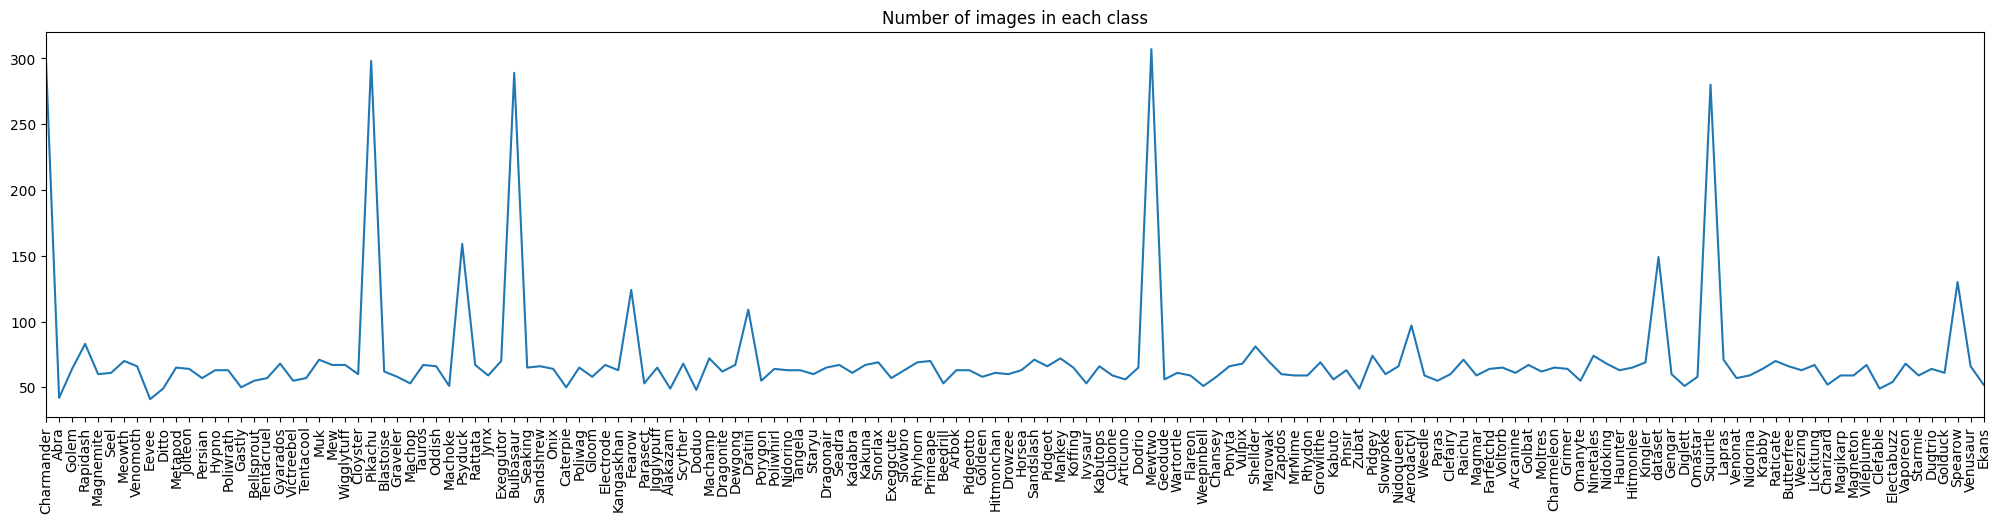

In [5]:
# A little bit of data exploration
path = './dataset' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))

print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [6]:


# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)


[('Mewtwo', 307), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


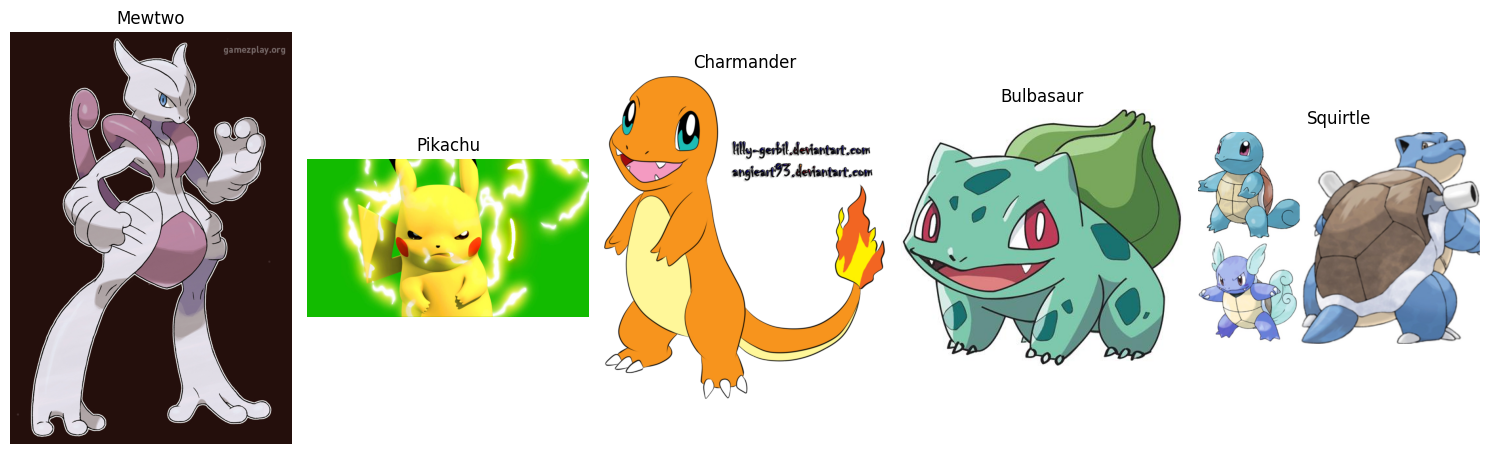

In [6]:
# Ruta base del dataset
dataset_path = "dataset"  # Cambia esto a la ruta correcta de tu dataset
imbalanced_classes = imbalanced

# Crear una figura para visualizar las imágenes
fig, axes = plt.subplots(1, len(imbalanced_classes), figsize=(15, 5))

for i, cls in enumerate(imbalanced_classes):
    # Ruta a la carpeta de la clase
    class_path = os.path.join(dataset_path, cls)

 # Seleccionar una imagen aleatoria de la clase
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)

    # Cargar la imagen
    img = Image.open(image_path)

    # Mostrar la imagen
    axes[i].imshow(img)
    axes[i].axis('off')  # Quitar ejes
    axes[i].set_title(cls)

plt.tight_layout()
plt.show()

In [7]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list

        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))

            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)

            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue

print('DONE')


./dataset/Mewtwo/ed9eb0e7d3494c6992e06196f5b7cc05.svg [ERROR] can't read the file
DONE


<ipython-input-8-db5df63598b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


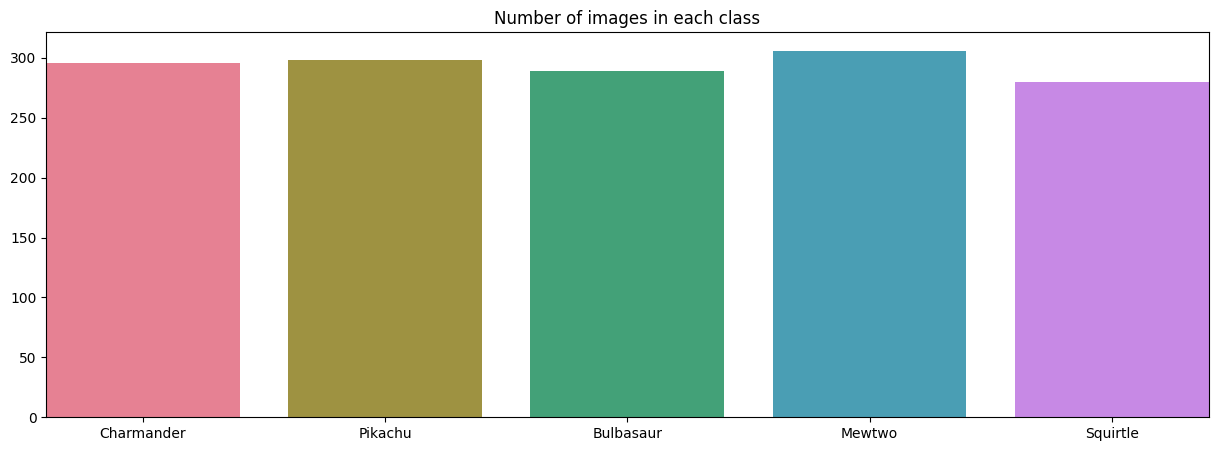

In [8]:
# Ejemplo de conteo
obj = Counter(Y)  # Reemplaza 'Y' con tu lista de etiquetas

# Crear una paleta de colores
unique_colors = sns.color_palette("husl", len(obj.keys()))  # Cambia "husl" por otra paleta si prefieres

# Graficar
fig = plt.figure(figsize=(15, 5))
sns.barplot(
    x=[imbalanced[i] for i in obj.keys()],
    y=list(obj.values()),
    palette=unique_colors  # Pasar los colores únicos
).set_title('Number of images in each class')

plt.margins(x=0)
plt.show()

In [9]:
# Asegúrate de que X es un numpy array
X = np.array(X, dtype=np.float32)

# Redimensionar y normalizar
X = X.reshape(-1, 96, 96, 3)  # Ajusta a tus dimensiones
X = X / 255.0  # Escalar a [0, 1]

num_classes = len(imbalanced)  # Asegúrate de definir el número de clases
y = to_categorical(Y, num_classes=num_classes)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=666,shuffle = True
)

In [10]:
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift
                            height_shift_range = 0.15, # Range for vertical shift
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

In [72]:
model = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),  # Dropout para reducir sobreajuste en el primer bloque

    # Bloque 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),  # Dropout después del segundo bloque

    # Bloque 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),  # Mayor Dropout en bloques más complejos

    # Bloque 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),  # Dropout consistente

    # Bloque 5
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.4),  # Dropout más alto para el último bloque

    # Clasificador
    Flatten(),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout en capas densas
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout en capas densas
    Dense(num_classes, activation='softmax')  # Capa de salida
])

# Resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 43,534,245 (166.07 MB)

 Trainable params: 43,512,101 (165.99 MB)

 Non-trainable params: 22,144 (86.50 KB)

In [12]:
checkpoint = ModelCheckpoint(
    filepath='./working/best_model.keras',  # Cambia la extensión a .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [13]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Generador con data augmentation
    epochs=100,  # Número de épocas
    validation_data=(X_test, y_test),  # Datos de validación
    steps_per_epoch=len(X_train) // 32,  # Número de pasos por época
    callbacks=[checkpoint]  # Callback para guardar el mejor modelo
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.3972 - loss: 4.6213
Epoch 1: val_accuracy improved from -inf to 0.21769, saving model to ./working/best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 750ms/step - accuracy: 0.3991 - loss: 4.6163 - val_accuracy: 0.2177 - val_loss: 12.2648
Epoch 2/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5625 - loss: 0.9587

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.21769 to 0.26871, saving model to ./working/best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5625 - loss: 0.9587 - val_accuracy: 0.2687 - val_loss: 12.6305
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5886 - loss: 1.8580
Epoch 3: val_accuracy did not improve from 0.26871
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 91ms/step - accuracy: 0.5892 - loss: 1.8495 - val_accuracy: 0.2347 - val_loss: 9.5121
Epoch 4/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7500 - loss: 0.9658
Epoch 4: val_accuracy did not improve from 0.26871
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.9658 - val_accuracy: 0.2177 - val_loss: 9.5955
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7095 - loss: 0.9617
Epoch 5: val_accuracy did not improve from 0.26871
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7098 - loss: 0.9614 - val_accuracy: 0.1973 - val_loss: 5.2877
Epoch 6/100
 1/36 ━━━━━

In [14]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')


Text(0.5, 1.0, 'loss')

In [73]:
# Loading weights from best model
model.load_weights('./working/best_model.keras')

# Saving all model
model.save('./working/model.keras')

In [33]:
mewtwo = ['https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg',
          'https://th.bing.com/th/id/OIP.ma5D3tlPTBwhMdlFdDneQwHaHa?w=208&h=208&c=7&r=0&o=5&dpr=1.4&pid=1.7',
          'https://vignette.wikia.nocookie.net/fantendo/images/3/3d/Mewtwo_shiny.png/revision/latest/scale-to-width-down/2000?cb=20160114003458',
          'https://static1.thegamerimages.com/wordpress/wp-content/uploads/2020/10/pjimage-2020-10-20T171315.091.jpg',
          'https://www.wallpaperflare.com/static/593/645/127/pok%C3%A9mon-mewtwo-pokemon-graphic-wallpaper.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
           'https://th.bing.com/th/id/R.be7dc5ce53cfa8a81d01d3389d194903?rik=EYHPHS%2bCGPnO2g&riu=http%3a%2f%2fimg1.wikia.nocookie.net%2f__cb20120603213349%2fsonicpokemon%2fimages%2f7%2f77%2fPikachu.png&ehk=rPWLFmhxA5gGXaEGy4OeQGixq2Y0NJ1Omlr7h6FzWvY%3d&risl=&pid=ImgRaw&r=0',
           'https://wallpapercave.com/wp/wp4566230.jpg',
           'https://wallpapercave.com/wp/wp1877515.jpg',
           'https://images.hdqwalls.com/download/cute-pikachu-6o-2560x1700.jpg',
           'https://webstockreview.net/images/pikachu-clipart-printable-1.png']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg',
              'https://th.bing.com/th/id/OIP.55K9-i1CvoiNOjVBNWP6kgHaHa?rs=1&pid=ImgDetMain',
              'https://img2.cgtrader.com/items/3910524/af9432ff94/pokemon-charmander-3d-model-stl.jpg',
              'https://images6.alphacoders.com/676/676249.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
              'https://th.bing.com/th/id/OIP.Vw7itzOg1Yc4kKb0seOTxwHaEo?w=305&h=190&c=7&r=0&o=5&dpr=1.4&pid=1.7',
             'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
             'https://th.bing.com/th/id/OIP.THjg4Ym6eHBUbbVMe6VZggHaEK?w=299&h=180&c=7&r=0&o=5&dpr=1.4&pid=1.7',
             'https://th.bing.com/th/id/OIP.cGCQ8IVnxGeg27GtaVFMpQHaHa?rs=1&pid=ImgDetMain',
             'https://w0.peakpx.com/wallpaper/385/979/HD-wallpaper-bulbasaur-pokemon-go-pokemon-anime.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg',
            'https://th.bing.com/th/id/OIP.3o73bPCKc_H2iL1cWj8rxwHaGL?rs=1&pid=ImgDetMain',
            'https://cdn.media.amplience.net/i/partycity/971449?$large$&fmt=auto&qlt=default',
            'https://files.cults3d.com/uploaders/22976645/illustration-file/d93293e1-edcb-4b25-bd05-330d7d3527ed/tbrender_001.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]

In [18]:
import requests

In [34]:
# Lists to store our future data
val_x = []
val_y = []

for i, urls in enumerate(test_df):
    for url in urls:
        r = requests.get(url, stream = True).raw
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv.imdecode(image, cv.IMREAD_COLOR)
        val_x.append(image)
        val_y.append(i)

Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

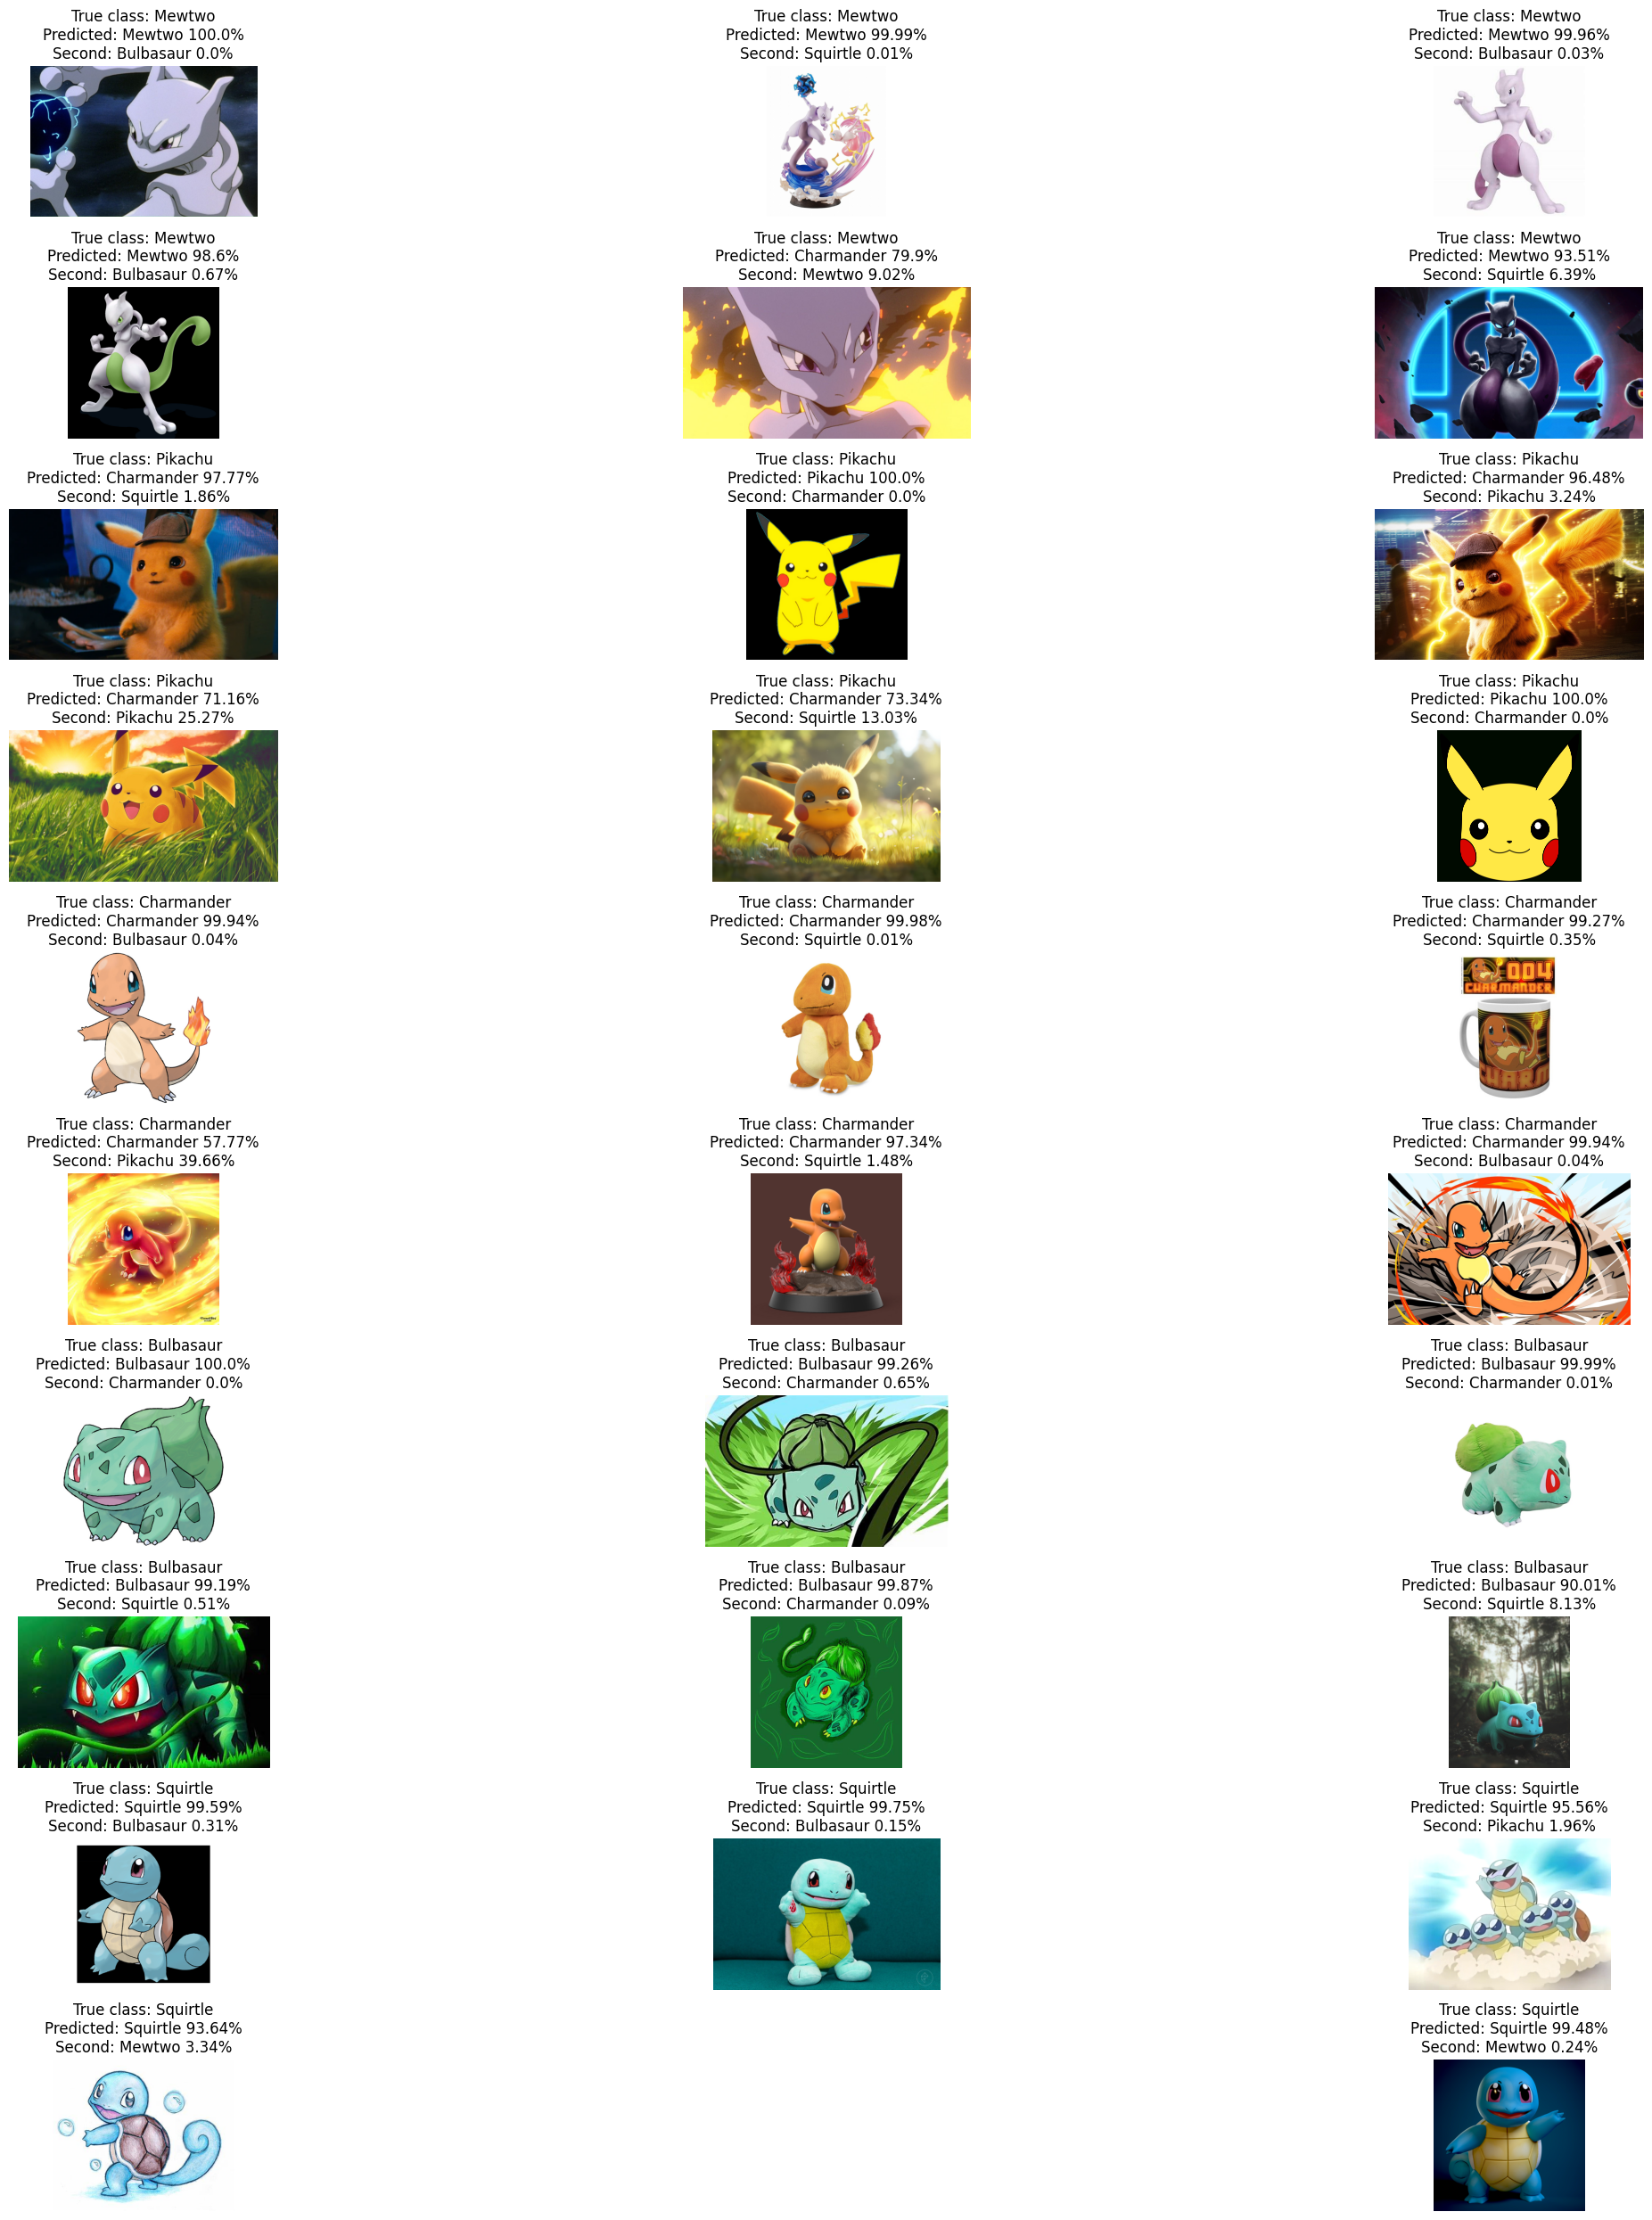

In [74]:
rows = 10
cols = 3

fig = plt.figure(figsize=(25, 25))

for i, j in enumerate(zip(val_x, val_y)):  # i - for subplots
    orig = j[0]  # Original, not resized image
    label = j[1]  # Label for that image

    # Verificar si la imagen está cargada
    if orig is None:
        print("Error: No se pudo cargar la imagen. Verifica la ruta.")
        continue

    print("Imagen cargada exitosamente.")
    image = cv.resize(orig, (96, 96))  # Resizing image to (96, 96)
    image = image.reshape(-1, 96, 96, 3) / 255.0  # Reshape and scale resized image
    preds = model.predict(image)  # Predicting image

    # Obtener los índices y valores de las dos predicciones más altas
    top_indices = np.argsort(preds[0])[-2:][::-1]  # Índices de las dos mayores probabilidades
    top_probs = preds[0][top_indices]  # Probabilidades correspondientes

    # Etiquetas y valores predichos
    true_label = f'True class: {imbalanced[label]}'
    pred_label = (f'Predicted: {imbalanced[top_indices[0]]} {round(top_probs[0] * 100, 2)}%\n'
                  f'Second: {imbalanced[top_indices[1]]} {round(top_probs[1] * 100, 2)}%')

    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}')
    plt.axis('off')

plt.tight_layout()

In [36]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [64]:
num_classes = 5

# Cargar el modelo VGG16 preentrenado, excluyendo la parte superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas densas personalizadas
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax')(x)  # Cambia num_classes al número de clases de tu dataset



# Crear el modelo final
model = Model(inputs=base_model.input, outputs=x)

checkpoint = ModelCheckpoint(
    filepath='./working/best_model_transferl.keras',  # Cambia la extensión a .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ver resumen del modelo
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,911,365 (60.70 MB)

 Trainable params: 1,196,677 (4.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Generador con data augmentation
    epochs=100,  # Ajusta el número de épocas
    validation_data=(X_test, y_test),  # Conjunto de validación
    steps_per_epoch=len(X_train) // 32,
        callbacks=[checkpoint]  # Añadir el callback
)

Epoch 1/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2567 - loss: 1.7404
Epoch 1: val_accuracy improved from -inf to 0.65306, saving model to ./working/best_model_transferl.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.2616 - loss: 1.7294 - val_accuracy: 0.6531 - val_loss: 1.2131
Epoch 2/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3125 - loss: 1.4161
Epoch 2: val_accuracy improved from 0.65306 to 0.65646, saving model to ./working/best_model_transferl.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3125 - loss: 1.4161 - val_accuracy: 0.6565 - val_loss: 1.2043
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5153 - loss: 1.2282
Epoch 3: val_accuracy improved from 0.65646 to 0.71769, saving model to ./working/best_model_transferl.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.5170 - loss: 1.2259 - val_accuracy: 0.7177 - val_loss: 0.9308
Epoch 4/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0

Text(0.5, 1.0, 'loss')

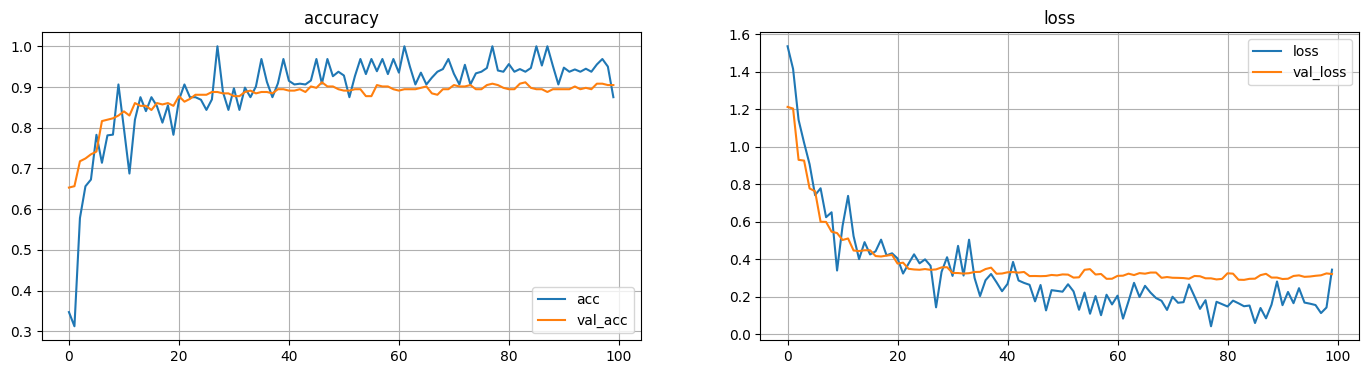

In [67]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [68]:
# Loading weights from best model
model.load_weights('./working/best_model_transferl.keras')

# Saving all model
model.save('./working/model_transferl.keras')

Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Imagen cargada exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

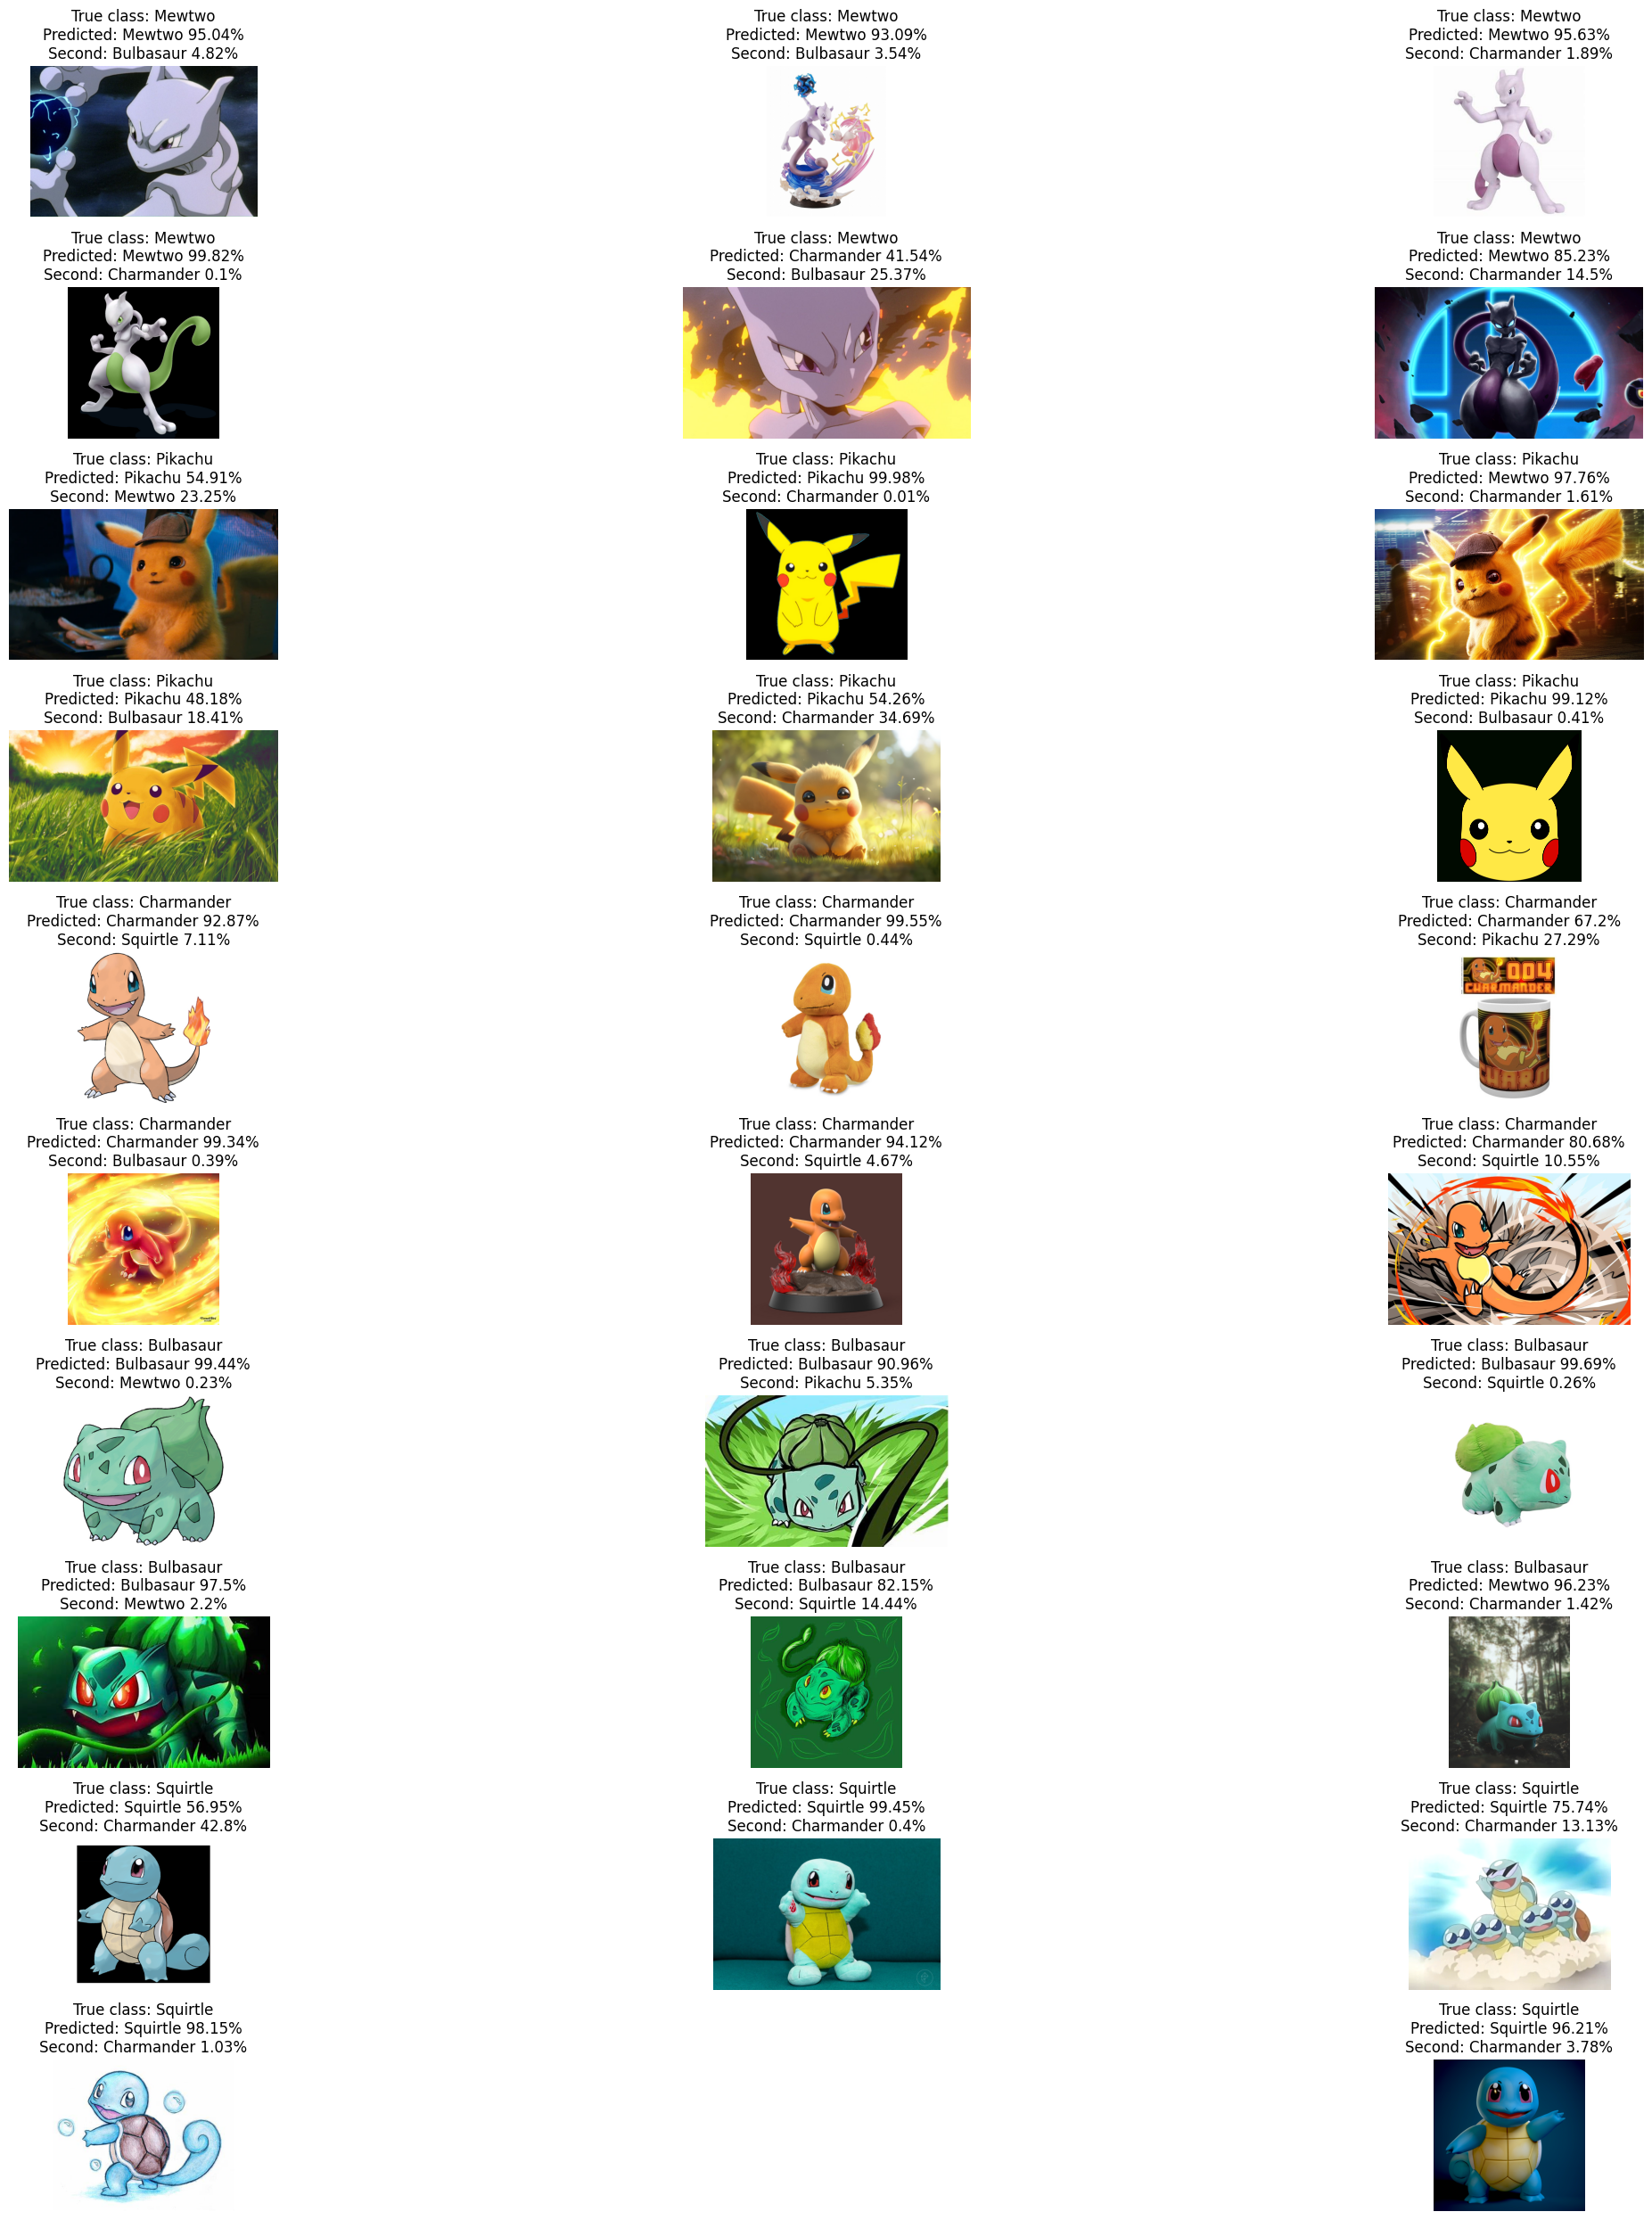

In [70]:
rows = 10
cols = 3

fig = plt.figure(figsize=(25, 25))

for i, j in enumerate(zip(val_x, val_y)):  # i - for subplots
    orig = j[0]  # Original, not resized image
    label = j[1]  # Label for that image

    # Verificar si la imagen está cargada
    if orig is None:
        print("Error: No se pudo cargar la imagen. Verifica la ruta.")
        continue

    print("Imagen cargada exitosamente.")
    image = cv.resize(orig, (96, 96))  # Resizing image to (96, 96)
    image = image.reshape(-1, 96, 96, 3) / 255.0  # Reshape and scale resized image
    preds = model.predict(image)  # Predicting image

    # Obtener los índices y valores de las dos predicciones más altas
    top_indices = np.argsort(preds[0])[-2:][::-1]  # Índices de las dos mayores probabilidades
    top_probs = preds[0][top_indices]  # Probabilidades correspondientes

    # Etiquetas y valores predichos
    true_label = f'True class: {imbalanced[label]}'
    pred_label = (f'Predicted: {imbalanced[top_indices[0]]} {round(top_probs[0] * 100, 2)}%\n'
                  f'Second: {imbalanced[top_indices[1]]} {round(top_probs[1] * 100, 2)}%')

    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}')
    plt.axis('off')

plt.tight_layout()

In [7]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list

        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))

            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)

            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue

print('DONE')

./dataset/Mewtwo/ed9eb0e7d3494c6992e06196f5b7cc05.svg [ERROR] can't read the file
DONE


In [8]:
# Convertir las listas a numpy arrays
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.int32)

# Normalizar imágenes a [-1, 1]
X = (X / 127.5) - 1

# Seleccionar imágenes de la clase objetivo
target_class_index = 0  # Cambia esto según la clase que quieras generar
target_class_images = X[Y == target_class_index]

print(f"Número de imágenes para la clase objetivo: {len(target_class_images)}")

Número de imágenes para la clase objetivo: 306


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2DTranspose, ReLU

def build_generator(latent_dim):
    model = Sequential([
        Dense(12 * 12 * 256, input_dim=latent_dim),
        BatchNormalization(),
        ReLU(),
        Reshape((12, 12, 256)),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


In [10]:
from tensorflow.keras.layers import Conv2D, Flatten, LeakyReLU, Dense

def build_discriminator(image_shape):
    model = Sequential([
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=image_shape),
        LeakyReLU(0.2),

        Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model


In [11]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [12]:
garbage_collector = GarbageCollectorCallback()

In [13]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Hiperparámetros
latent_dim = 100
image_shape = target_class_images.shape[1:]

# Construir el generador y el discriminador
generator = build_generator(latent_dim)
discriminator = build_discriminator(image_shape)

# Compilar el discriminador
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Congelar el discriminador para entrenar la GAN
discriminator.trainable = False

# Crear la GAN combinando generador y discriminador
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0/10000 [D loss: 0.684762716293335 | D acc: 62.5] [G loss: [array(0.68759024, dtype=float32), array(0.68759024, dtype=float32), array(0.5, dtype=float32)]]


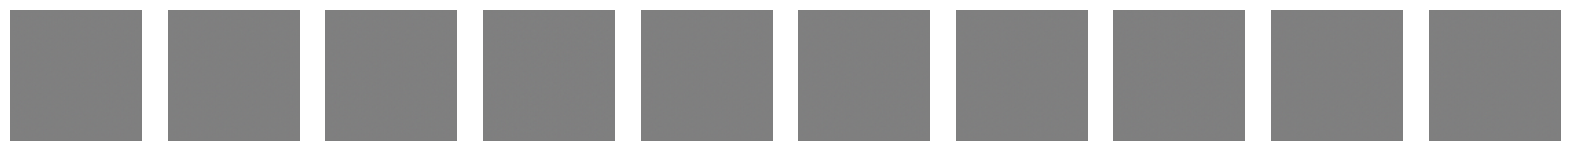

50/10000 [D loss: 0.6970927715301514 | D acc: 37.68564462661743] [G loss: [array(0.6974308, dtype=float32), array(0.6974308, dtype=float32), array(0.375, dtype=float32)]]


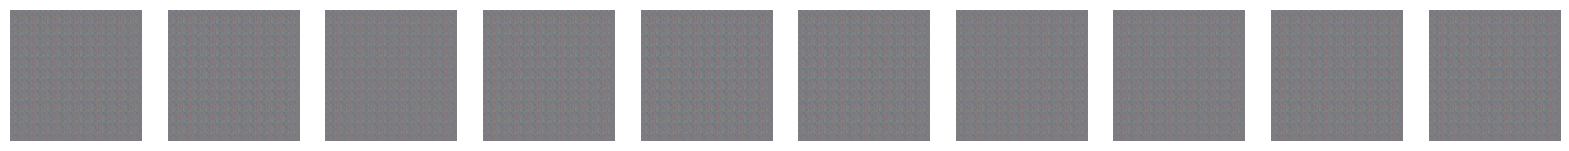

100/10000 [D loss: 0.717178225517273 | D acc: 37.46921420097351] [G loss: [array(0.71754235, dtype=float32), array(0.71754235, dtype=float32), array(0.37376237, dtype=float32)]]


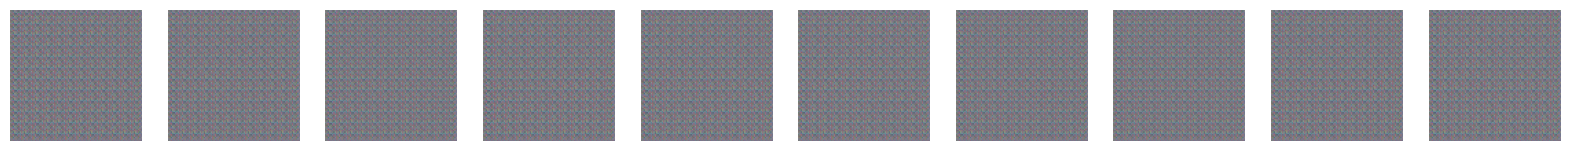

KeyboardInterrupt: 

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gc

@tf.function
def train_discriminator(discriminator, real_images, fake_images):
    real_labels = tf.ones((real_images.shape[0], 1))
    fake_labels = tf.zeros((fake_images.shape[0], 1))

    with tf.GradientTape() as tape:
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_images, training=True))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_images, training=True))
        d_loss = tf.reduce_mean(real_loss + fake_loss)

    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    return d_loss

@tf.function
def train_generator(generator, discriminator, batch_size, latent_dim):
    noise = tf.random.normal((batch_size, latent_dim))
    valid_labels = tf.ones((batch_size, 1))

    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        predictions = discriminator(fake_images, training=True)
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(valid_labels, predictions))

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator.optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return g_loss

def train_gan(generator, discriminator, gan, dataset, latent_dim, epochs=10000, batch_size=8):
    for epoch in range(epochs):
        # Obtener imágenes reales
        indices = np.random.randint(0, dataset.shape[0], batch_size)
        real_images = dataset[indices]

        # Generar imágenes falsas
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator(noise, training = False)

        # Entrenar el discriminador
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenar el generador
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Mostrar progreso
        if epoch % 50 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D acc: {100 * d_loss[1]}] [G loss: {g_loss}]")
            if epoch % 50 == 0:
                plot_generated_images(generator, latent_dim)
        del real_images, fake_images, noise
        garbage_collector.on_epoch_end(epoch)


def plot_generated_images(generator, latent_dim, examples=10, dim=(1, 10), figsize=(20, 5)):
    noise = tf.random.normal((examples, latent_dim))
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2  # Escalar de nuevo a [0, 1]

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()
    plt.close()


# Entrenar la GAN
train_gan(generator, discriminator, gan, target_class_images, latent_dim, epochs=10000, batch_size=8)
